In [2]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
import librosa
import h5py
import os

In [3]:
metadata = "../UrbanSound8K/metadata/UrbanSound8K.csv"
metadata_df = pd.read_csv(metadata)

labels = metadata_df['class'].unique()    # obtaining the class labels
print(labels)

['dog_bark' 'children_playing' 'car_horn' 'air_conditioner' 'street_music'
 'gun_shot' 'siren' 'engine_idling' 'jackhammer' 'drilling']


In [4]:
metadata_df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


## Reflective padding: our alternative to zero padding 

Reflective padding:

    Reflecting the signal at its boundaries instead of zero padding can help preserve the continuity of the signal, preventing alterations of the signal's characteristics, something that might occur with zero padding.
    It can also help reducing artifacts at the edges of the signal and providing a smooth transition from the original signal to the padded region.
    We believe this approach is effective with sound data, due to its symmetric nature.

In [5]:
def reflective_padding(signal, target_duration, target_rate):
    target_duration = target_duration*target_rate
    current_duration = len(signal)
    
    # Calculate the required padding on each side
    padding_needed = target_duration - current_duration
    left_padding = padding_needed // 2
    right_padding = padding_needed - left_padding
    
    # Reflective padding on both sides
    padded_signal = np.pad(signal, (left_padding, right_padding), 'reflect')
    
    return padded_signal

## Loading and resampling all the data

#### Parameters definition

In [6]:
signal_time = 4    # each signal will have 4 seconds of duration
target_rate = 1000    # resampling frequence

# MFCC parameters
n_mfcc=40
hop_length=round(target_rate*0.0125)
win_length=round(target_rate*0.023)
n_fft=2**14
mfcc_time_size = 4*target_rate//hop_length+1

dataset = []
dataset_mfcc = []
labels = []

#### Obtaining all the resampled data

In [7]:
# Calculating an auxiliar index that allows for obtaining only the file name from the full path, so that the pre-processing can be done for whatever full path a machine has.
_wav_dir_="../UrbanSound8K/audio/fold1/"
files = librosa.util.find_files(_wav_dir_)
f = files[0]            # obtaining the 1st file of the 1st fols
f_name_length = 16      # 1st file's length
string_truncation_idx = len(f[:len(f)-f_name_length])   # number of characters of the file's absolute path before the file name

In [8]:
for i in range(1,11):
    _wav_dir_="../UrbanSound8K/audio/fold" + str(i) + '/'
    files = librosa.util.find_files(_wav_dir_)
    fold=np.zeros(shape=[len(files),4*target_rate])
    fold_mfcc=np.zeros(shape=[len(files),n_mfcc,mfcc_time_size])
    fold_labels = []
    idx = 0
    if i >= 10: string_truncation_idx += 1     # the file path length before the file name grows by 1 when accessing fold 10, so the string truncation index also has to increase by 1
    for f in files:
        fold_labels.append(metadata_df[str(f)[string_truncation_idx:]==metadata_df['slice_file_name']]['class'].values[0])  # getting and storing this sample's label
        signal, rate = librosa.load(f, sr=None)
        new_signal = librosa.resample(signal, orig_sr=rate, target_sr=target_rate)
        if len(new_signal) < 4*target_rate:
            new_signal = reflective_padding(new_signal, 4, target_rate)
        fold[idx] = new_signal[:4000]   # reducing the signal to its first 4 seconds
        sig_mfcc = librosa.feature.mfcc(y=new_signal,sr=target_rate,n_fft=n_fft,hop_length=hop_length,win_length=win_length,n_mfcc=n_mfcc)
        fold_mfcc[idx] = sig_mfcc[:,:334]   # reducing the mfcc matrix to the elements corresponding to the first 4 seconds of the signal 
        idx += 1
    dataset.append(fold)
    dataset_mfcc.append(fold_mfcc)
    labels.append(fold_labels)
    print(f"fold {i} done")

AttributeError: module 'numpy' has no attribute 'long'

## Visualizing an audio sample

Originally, the 545th sample of the 5th fold wasn't properly resampled to the target rate of 4000. Instead, the 'librosa.resample' function would return a signal of length 4008.
Thus, we decided to analyze this particular sample.

Resampled signal's length: 4008


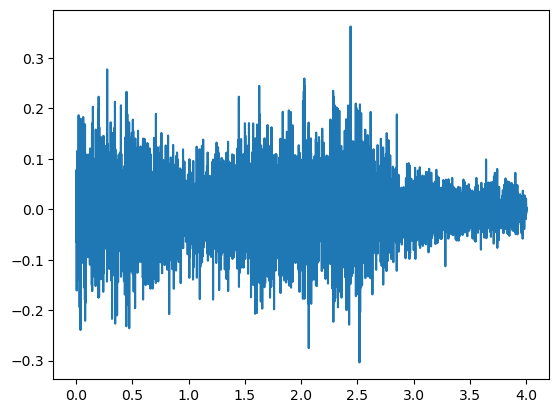

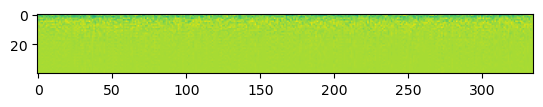

In [29]:
_wav_dir_="../UrbanSound8K/audio/fold5/"
files = librosa.util.find_files(_wav_dir_)
sample = files[545]

signal, rate = librosa.load(sample, sr=None)
new_signal = librosa.resample(signal, orig_sr=rate, target_sr=target_rate)
print(f"Resampled signal's length: {len(new_signal)}")
sig_mfcc =librosa.feature.mfcc(y=new_signal,sr=target_rate,n_fft=n_fft,hop_length=hop_length,win_length=win_length,n_mfcc=n_mfcc)

plt.figure()
plt.plot(np.asarray(list(range(4008)))/1000,new_signal)
plt.show()

plt.figure()
plt.imshow(sig_mfcc)
plt.show()

Since there is no visible anomaly in this audio sample, we decided to truncate the extra signal length that was causing the anomaly and applied this rule to the dataset as a whole.

#### Example of another audio sample

When analyzing the dataset, we noticed this audio sample, among others, had only zeros in its first several attributes.

c:\Users\gapmd\workspace\GitHub projects\AC II - project\UrbanSound8K\audio\fold1\143651-2-0-0.wav
Resampled signal's length: 4000


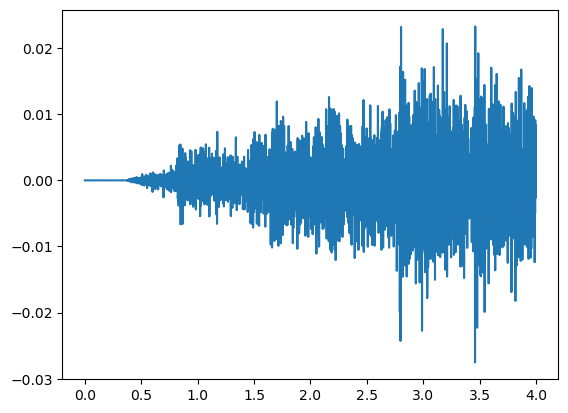

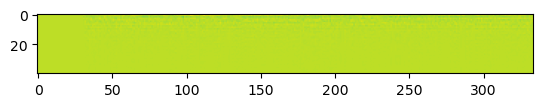

In [31]:
_wav_dir_="../UrbanSound8K/audio/fold1/"
files = librosa.util.find_files(_wav_dir_)
sample = files[199]
print(sample)

signal, rate = librosa.load(sample, sr=None)
new_signal = librosa.resample(signal, orig_sr=rate, target_sr=target_rate)
print(f"Resampled signal's length: {len(new_signal)}")
sig_mfcc =librosa.feature.mfcc(y=new_signal,sr=target_rate,n_fft=n_fft,hop_length=hop_length,win_length=win_length,n_mfcc=n_mfcc)

plt.figure()
plt.plot(np.asarray(list(range(4000)))/1000,new_signal)
plt.show()

plt.figure()
plt.imshow(sig_mfcc)
plt.show()

After analyzing its signal, we concluded that these audios are not defected, instead they just have varying start times.

## Saving the datasets

Each fold containing the audio signals was saved in its own 'csv' file.

In [25]:
for i in range(1,11):
    path = "datasets/fold" + str(i) + ".csv"
    np.savetxt(path, dataset[i-1], delimiter=',', fmt='%f')

The dataset containing all the MFCC features was saved in one 'h5' file.

In [ ]:
for i in range(1,11):
    path = "datasets/mfcc_fold" + str(i) + ".h5"
    with h5py.File('datasets/mfcc_dataset.h5', 'w') as hf:
        hf.create_dataset('mfcc_dataset', data=dataset_mfcc[i-1])